In [57]:
from __future__ import division, print_function
from keras.callbacks import ModelCheckpoint
from keras.layers import Dense, Dropout, BatchNormalization
from keras.models import Sequential
from keras.models import Model
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt

### Read data

In [3]:
data = pd.read_csv('imdb_labelled.tsv', header = None, delimiter='\t')

In [4]:
data.columns = ['Text', 'Label']

In [5]:
data.head()

,Text,Label
0,"A very, very, very slow-moving, aimless movie ...",0
1,Not sure who was more lost - the flat characte...,0
2,Attempting artiness with black & white and cle...,0
3,Very little music or anything to speak of.,0
4,The best scene in the movie was when Gerardo i...,1


In [6]:
data.Label.unique()

array([0, 1])

In [7]:
data.shape

(748, 2)

In [8]:
pos = []
neg = []
for l in data.Label:
    if l == 0:
        pos.append(0)
        neg.append(1)
    elif l == 1:
        pos.append(1)
        neg.append(0)

In [9]:
data['Pos']= pos
data['Neg']= neg

In [10]:
data.head()

,Text,Label,Pos,Neg
0,"A very, very, very slow-moving, aimless movie ...",0,0,1
1,Not sure who was more lost - the flat characte...,0,0,1
2,Attempting artiness with black & white and cle...,0,0,1
3,Very little music or anything to speak of.,0,0,1
4,The best scene in the movie was when Gerardo i...,1,1,0


### Split data into test and train

In [11]:
data_train, data_test = train_test_split(data, test_size=0.10, random_state=42)

### Load Universal Sentence Encoder

In [12]:
module_url = "https://tfhub.dev/google/universal-sentence-encoder-large/2" 
embed = hub.Module(module_url)

Instructions for updating:
Colocations handled automatically by placer.


W0920 15:19:05.644642 140561273198336 deprecation.py:323] From /home/saadarshad/anaconda3/envs/amna_bot/lib/python3.6/site-packages/tensorflow/python/ops/control_flow_ops.py:3632: colocate_with (from tensorflow.python.framework.ops) is deprecated and will be removed in a future version.
Instructions for updating:
Colocations handled automatically by placer.


### Get Embeddings

In [13]:
with tf.Session() as session:
    session.run([tf.global_variables_initializer(), tf.tables_initializer()])
    training_embeddings = session.run(embed(data_train.Text.to_list()))

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0920 15:19:15.945204 140561273198336 saver.py:1483] Saver not created because there are no variables in the graph to restore


In [14]:
MAX_SEQUENCE_LENGTH = 50
EMBEDDING_DIM = 512

### Define CNN

In [15]:
label_names = ['Pos', 'Neg']

In [98]:
y_train = data_train[label_names].values

In [114]:
model = Sequential()
model.add(Dense(128, activation = 'relu'))
model.add(Dense(2, activation = 'softmax'))

In [115]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])

In [121]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 128)               65664     
_________________________________________________________________
dense_10 (Dense)             (None, 2)                 258       
Total params: 65,922
Trainable params: 65,922
Non-trainable params: 0
_________________________________________________________________


### Train CNN

In [119]:
num_epochs = 4
batch_size = 32

In [120]:
history = model.fit(training_embeddings, y_train, epochs=num_epochs, validation_split=0.1, shuffle=True, batch_size=batch_size)

Train on 605 samples, validate on 68 samples
Epoch 1/4
605/605 [==============================] - 4s 6ms/step - loss: 0.6350 - acc: 0.6744 - val_loss: 0.5320 - val_acc: 0.9118
Epoch 2/4
605/605 [==============================] - 0s 141us/step - loss: 0.4675 - acc: 0.8876 - val_loss: 0.3505 - val_acc: 0.9118
Epoch 3/4
605/605 [==============================] - 0s 137us/step - loss: 0.3283 - acc: 0.9041 - val_loss: 0.2432 - val_acc: 0.9265
Epoch 4/4
605/605 [==============================] - 0s 124us/step - loss: 0.2576 - acc: 0.9025 - val_loss: 0.2001 - val_acc: 0.9412


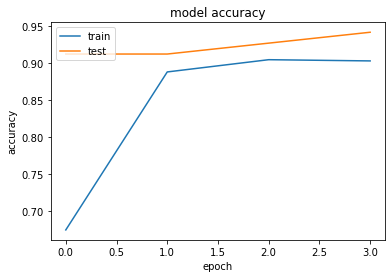

In [122]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

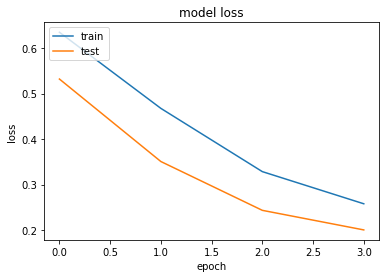

In [123]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### Test CNN

In [124]:
with tf.Session() as session:
    session.run([tf.global_variables_initializer(), tf.tables_initializer()])
    test_embeddings = session.run(embed(data_test.Text.to_list()))

In [125]:
predictions = model.predict(test_embeddings, batch_size=1024, verbose=1)

75/75 [==============================] - 1s 15ms/step


In [126]:
labels = [1, 0]

In [127]:
prediction_labels=[]
for p in predictions:
    prediction_labels.append(labels[np.argmax(p)])

In [128]:
print("Accuracy:", sum(data_test.Label==prediction_labels)/len(prediction_labels))

Accuracy: 0.9333333333333333
